# Market Basket Analysis in Python using Apriori Algorithm

Amazon, Netflix and many other popular companies rely on Market Basket Analysis to produce meaningful product recommendations. Market Basket Analysis is a powerful tool for translating vast amounts of customer transaction and viewing data into simple rules for product promotion and recommendation. In this notebook, we’ll learn how to perform Market Basket Analysis using the Apriori algorithm, standard and custom metrics, association rules, aggregation and pruning, and visualization.

# What is market basket analysis?

1. Identify products frequently purchased together.
        
        Bookstore Ex:

            Biography and history
            Fiction and poetry

2. Construct recommendations based on these

        Bookstore Ex:

            Place biography and history sections together.
            Keep fiction and history apart

# The use cases of market basket analysis

1. Build Netflix-style recommendations engine.

2. Improve product recommendations on an e-commerce store.

3. Cross-sell products in a retail setting.

4. Improve inventory management.

5. Upsell products.

### Market basket analysis

    Construct association rules

    Identify items frequently purchased together

### Association rules

    {antecedent}→{consequent}

        {fiction}→{biography}

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [6]:
sns.set(style="darkgrid", color_codes=True)
pd.set_option('display.max_columns', 75)

# Data set

### The contains information about customers buying different grocery items.

In [14]:
data = pd.read_csv('Market_Basket_Optimisation.csv', header = None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [15]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.describe()

,0,1,2
count,38766,38766,38766
unique,3899,729,168
top,3180,21-01-2015,whole milk
freq,36,96,2502


# Exploratory data analysis

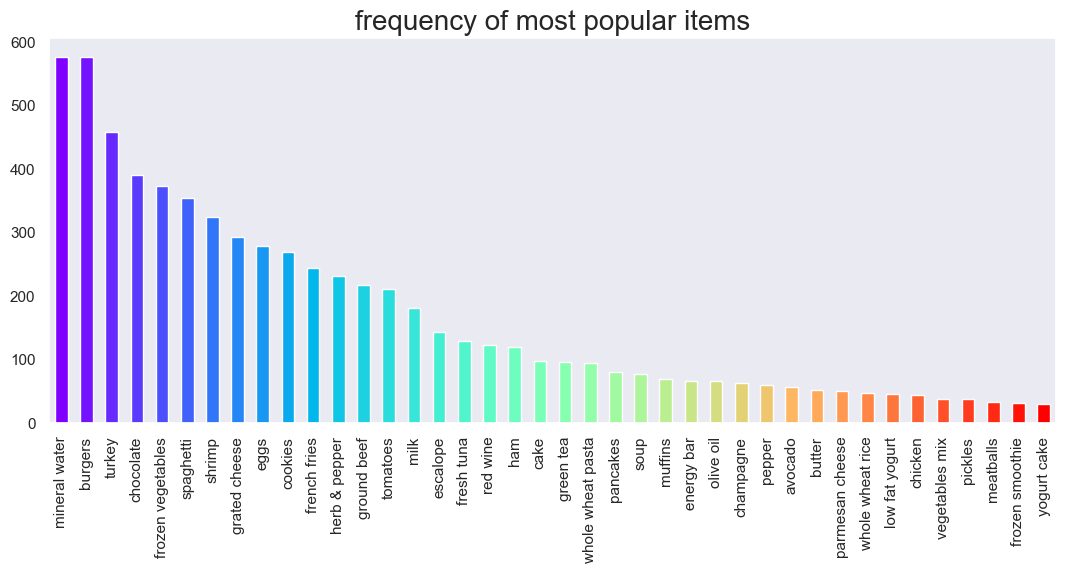

In [16]:
color = plt.cm.rainbow(np.linspace(0, 1, 40))
data[0].value_counts().head(40).plot.bar(color = color, figsize=(13,5))
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [17]:
import networkx as nx
data['food'] = 'Food'
food = data.truncate(before = -1, after = 15)
food = nx.from_pandas_edgelist(food, source = 'food', target = 0, edge_attr = True)

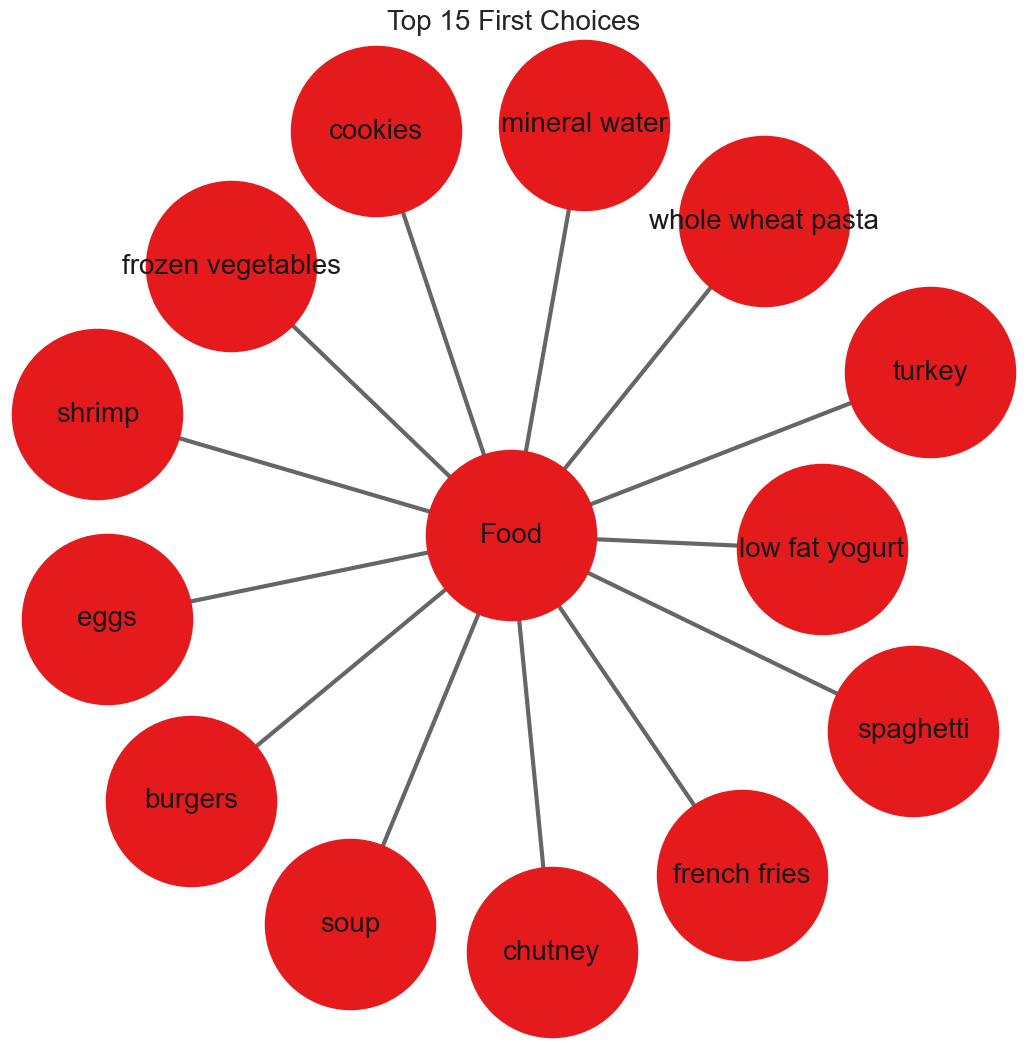

In [18]:
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (13, 13)
pos = nx.spring_layout(food)
color = plt.cm.Set1(np.linspace(0, 15, 1))
nx.draw_networkx_nodes(food, pos, node_size = 15000, node_color = color)
nx.draw_networkx_edges(food, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(food, pos, font_size = 20, font_family = 'sans-serif')
plt.axis('off')
plt.grid()
plt.title('Top 15 First Choices', fontsize = 20)
plt.show()

# Getting the list of transactions

In [19]:
# Getting the list of transactions from the dataset
transactions = []
for i in range(0, len(data)):
    transactions.append([str(data.values[i,j]) for j in range(0, len(data.columns))])

In [20]:
transactions[:1]


[['shrimp',
  'almonds',
  'avocado',
  'vegetables mix',
  'green grapes',
  'whole weat flour',
  'yams',
  'cottage cheese',
  'energy drink',
  'tomato juice',
  'low fat yogurt',
  'green tea',
  'honey',
  'salad',
  'mineral water',
  'salmon',
  'antioxydant juice',
  'frozen smoothie',
  'spinach',
  'olive oil',
  'Food']]

# Association rules
### Association rule
Contains antecedent and consequent
{health} → {cooking}
Multi-antecedent rule
{humor, travel} → {language}
### Multi-consequent rule
{biography} → {history, language}
### Multi-antecedent and consequent rule
{biography, non-fiction} → {history, language}
## Difficulty of selecting rules
#### Finding useful rules is difficult.
Set of all possible rules is large.
Most rules are not useful.
Must discard most rules.
#### What if we restrict ourselves to simple rules?
One antecedent and one consequent.
Still challenging, even for small dataset.

In [21]:
from itertools import permutations

# Extract unique items.
flattened = [item for transaction in transactions for item in transaction]
items = list(set(flattened))

In [22]:
print('# of items:',len(items))
print(list(items))

# of items: 122
['green grapes', 'sparkling water', 'black tea', 'herb & pepper', 'cake', 'light mayo', 'shallot', 'grated cheese', 'low fat yogurt', 'salmon', 'whole wheat pasta', 'frozen vegetables', 'green beans', 'shampoo', 'tea', 'oatmeal', 'energy bar', 'shrimp', 'clothes accessories', 'melons', 'escalope', 'rice', 'toothpaste', 'nan', 'magazines', 'cooking oil', 'muffins', 'chili', 'zucchini', 'pancakes', 'strawberries', 'bacon', 'milk', 'hand protein bar', 'eggs', 'cream', 'Food', 'dessert wine', 'pickles', 'corn', 'fresh bread', 'asparagus', 'oil', 'mineral water', 'pasta', 'chutney', 'blueberries', 'spaghetti', 'mushroom cream sauce', 'butter', 'flax seed', 'energy drink', 'antioxydant juice', 'ground beef', 'carrots', 'hot dogs', 'meatballs', 'burgers', 'parmesan cheese', 'brownies', 'green tea', 'sandwich', 'avocado', 'mint green tea', 'chocolate', 'spinach', 'almonds', 'honey', 'yogurt cake', 'ham', 'salt', 'gums', 'french wine', 'salad', 'bramble', 'water spray', 'candy b

In [23]:
if 'nan' in items: items.remove('nan')
print(list(items))

['green grapes', 'sparkling water', 'black tea', 'herb & pepper', 'cake', 'light mayo', 'shallot', 'grated cheese', 'low fat yogurt', 'salmon', 'whole wheat pasta', 'frozen vegetables', 'green beans', 'shampoo', 'tea', 'oatmeal', 'energy bar', 'shrimp', 'clothes accessories', 'melons', 'escalope', 'rice', 'toothpaste', 'magazines', 'cooking oil', 'muffins', 'chili', 'zucchini', 'pancakes', 'strawberries', 'bacon', 'milk', 'hand protein bar', 'eggs', 'cream', 'Food', 'dessert wine', 'pickles', 'corn', 'fresh bread', 'asparagus', 'oil', 'mineral water', 'pasta', 'chutney', 'blueberries', 'spaghetti', 'mushroom cream sauce', 'butter', 'flax seed', 'energy drink', 'antioxydant juice', 'ground beef', 'carrots', 'hot dogs', 'meatballs', 'burgers', 'parmesan cheese', 'brownies', 'green tea', 'sandwich', 'avocado', 'mint green tea', 'chocolate', 'spinach', 'almonds', 'honey', 'yogurt cake', 'ham', 'salt', 'gums', 'french wine', 'salad', 'bramble', 'water spray', 'candy bars', 'bug spray', 'cer

In [24]:
# Compute and print rules.
rules = list(permutations(items, 2))
print('# of rules:',len(rules))
print(rules[:5])

# of rules: 14520
[('green grapes', 'sparkling water'), ('green grapes', 'black tea'), ('green grapes', 'herb & pepper'), ('green grapes', 'cake'), ('green grapes', 'light mayo')]


# One-hot encoding transaction data

Throughout we will use a common pipeline for preprocessing data for use in market basket analysis. The first step is to import a pandas DataFrame and select the column that contains transactions. Each transaction in the column will be a string that consists of a number of items, each separated by a comma. The next step is to use a lambda function to split each transaction string into a list, thereby transforming the column into a list of lists. Then we will transform the transactions into a one-hot encoded DataFrame, where each column consists of TRUE and FALSE values that indicate whether an item was included in a transaction.

In [25]:
# Import the transaction encoder function from mlxtend
from mlxtend.preprocessing import TransactionEncoder

# Instantiate transaction encoder and identify unique items
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_).drop('nan', axis=1)

# Print the one-hot encoded transaction dataset
onehot.head()

,asparagus,Food,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,...,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


 # Metrics and pruning
1. A metric is a measure of performance for rules.
    
    a. {humor} → {poetry}
     
       i. 0.81
     
     b. {fiction} → {travel}
        
        i. 0.23

2.Pruning is the use of metrics to discard rules.

      a.Retain: {humor} → {poetry}

      b. Discard: { ction} → {travel}

In [26]:
# Compute the support
support = onehot.mean()
support = pd.DataFrame(support, columns=['support']).sort_values('support',ascending=False)

# Print the support
support.head()

,support
Food,1.000000
mineral water,0.238368
eggs,0.179709
spaghetti,0.174110
french fries,0.170911


In [27]:
support.describe()

,support
count,121.000000
mean,0.040611
std,0.097542
min,0.000133
25%,0.007732
50%,0.015731
75%,0.042528
max,1.000000


# Confidence and lift
### When support is misleading

1. Milk and bread frequently purchased together.
        
        Support: {Milk} → {Bread}

2. Rule is not informative for marketing.

        Milk and bread are both independently popular items.

In [28]:
# Compute support for burgers and french fries
supportBF = np.logical_and(onehot['burgers'], onehot['french fries']).mean()

# Compute support for burgers and mineral water
supportBM = np.logical_and(onehot['burgers'], onehot['mineral water']).mean()

# Compute support for french fries and mineral water
supportFM = np.logical_and(onehot['french fries'], onehot['mineral water']).mean()

# Print support values
print("burgers and french fries: %.2f" % supportBF)
print("burgers and mineral water: %.2f" % supportBM)
print("french fries and mineral water: %.2f" % supportFM)

burgers and french fries: 0.02
burgers and mineral water: 0.02
french fries and mineral water: 0.03


# Computing the support metric

In [29]:
# Add a mineral water+french fries column to the DataFrame onehot
onehot['mineral water+french fries'] = np.logical_and(onehot['mineral water'], onehot['french fries'])

# Compute the support
support = onehot.mean()
val = support.loc['mineral water+french fries']

# Print the support values
print(f'mineral water+french fries support = {val}')

mineral water+french fries support = 0.03372883615517931


# Refining support with confidence

In [30]:
# Compute support for mineral water and french fries
supportMF = np.logical_and(onehot['mineral water'], onehot['french fries']).mean()

# Compute support for mineral water
supportM = onehot['mineral water'].mean()

# Compute support for french fries
supportF = onehot['french fries'].mean()

# Compute confidence for both rules
confidenceMM = supportMF / supportM
confidenceMF = supportMF / supportF

# Print results
print('mineral water = {0:.2f}, french fries = {1:.2f}'.format(confidenceMM, confidenceMF))

mineral water = 0.14, french fries = 0.20


# Further refinement with lift

In [ ]:
# Compute lift
lift = supportMF / (supportM * supportF)

# Print lift
print("Lift: %.2f" % lift)

# Leverage and Conviction

In [31]:
# Compute support for burgers AND french fries
supportBF = np.logical_and(onehot['burgers'], onehot['french fries']).mean()

# Compute support for burgers
supportB = onehot['burgers'].mean()

# Compute support for NOT french fries
supportnF = 1.0 - onehot['french fries'].mean()

# Compute support for burgers and NOT french fries
supportBnF = supportB - supportBF

# Compute and print conviction for burgers -> french fries
conviction = supportB * supportnF / supportBnF
print("Conviction: %.2f" % conviction)

Conviction: 1.11


# Computing conviction with a function

In [32]:
def conviction(antecedent, consequent):
    # Compute support for antecedent AND consequent
    supportAC = np.logical_and(antecedent, consequent).mean()

    # Compute support for antecedent
    supportA = antecedent.mean()

    # Compute support for NOT consequent
    supportnC = 1.0 - consequent.mean()

    # Compute support for antecedent and NOT consequent
    supportAnC = supportA - supportAC

    # Return conviction
    return supportA * supportnC / supportAnC

# Computing leverage with a function

In [33]:
def leverage(antecedent, consequent):
    # Compute support for antecedent AND consequent
    supportAB = np.logical_and(antecedent, consequent).mean()

    # Compute support for antecedent
    supportA = antecedent.mean()

    # Compute support for consequent
    supportB = consequent.mean()

    # Return leverage
    return supportAB - supportB * supportA

# Promoting food with conviction

In [34]:
# Compute conviction for burgers -> french fries and french fries -> burgers
convictionBF = conviction(onehot['burgers'], onehot['french fries'])
convictionFB = conviction(onehot['french fries'], onehot['burgers'])

# Compute conviction for burgers -> mineral water and mineral water -> burgers
convictionBM = conviction(onehot['burgers'], onehot['mineral water'])
convictionMB = conviction(onehot['mineral water'], onehot['burgers'])

# Compute conviction for french fries -> mineral water and mineral water -> french fries
convictionFM = conviction(onehot['french fries'], onehot['mineral water'])
convictionMF = conviction(onehot['mineral water'], onehot['french fries'])

# Print results
print('french fries -> burgers: ', convictionFB)
print('burgers -> french fries: ', convictionBF)

french fries -> burgers:  1.0476495106531305
burgers -> french fries:  1.1088435652342468


# Computing association and dissociation

In [36]:
# Compute the support of burgers and french fries
supportT = onehot['burgers'].mean()
supportP = onehot['french fries'].mean()

# Compute the support of both food items
supportTP = np.logical_and(onehot['burgers'], onehot['french fries']).mean()

# Complete the expressions for the numerator and denominator
numerator = supportTP - supportT*supportP
denominator = max(supportTP*(1-supportT), supportT*(supportP-supportTP))

# Compute and print Zhang's metric
zhang = numerator / denominator
print(zhang)

0.3533836982354581


# Defining Zhang's metric

In [37]:
# Define a function to compute Zhang's metric
def zhang(antecedent, consequent):
    # Compute the support of each book
    supportA = antecedent.mean()
    supportC = consequent.mean()

    # Compute the support of both books
    supportAC = np.logical_and(antecedent, consequent).mean()

    # Complete the expressions for the numerator and denominator
    numerator = supportAC - supportA*supportC
    denominator = max(supportAC*(1-supportA), supportA*(supportC-supportAC))

    # Return Zhang's metric
    return numerator / denominator

# Applying Zhang's metric

In [38]:
# Create rules DataFrame
rules_ = pd.DataFrame(rules, columns=['antecedents','consequents'])

# Define an empty list for metrics
zhangs, conv, lev, antec_supp, cons_supp, suppt, conf, lft = [], [], [], [], [], [], [], []

# Loop over lists in itemsets
for itemset in rules:
    # Extract the antecedent and consequent columns
    antecedent = onehot[itemset[0]]
    consequent = onehot[itemset[1]]
    
    antecedent_support = onehot[itemset[0]].mean()
    consequent_support = onehot[itemset[1]].mean()
    support = np.logical_and(onehot[itemset[0]], onehot[itemset[1]]).mean()
    confidence = support / antecedent_support
    lift = support / (antecedent_support * consequent_support)
    
    # Complete metrics and append it to the list
    antec_supp.append(antecedent_support)
    cons_supp.append(consequent_support)
    suppt.append(support)
    conf.append(confidence)
    lft.append(lift)
    lev.append(leverage(antecedent, consequent))
    conv.append(conviction(antecedent, consequent))
    zhangs.append(zhang(antecedent, consequent))
    
# Store results
rules_['antecedent support'] = antec_supp
rules_['consequent support'] = cons_supp
rules_['support'] = suppt
rules_['confidence'] = conf
rules_['lift'] = lft
rules_['leverage'] = lev
rules_['conviction'] = conv
rules_['zhang'] = zhangs

# Print results
rules_.sort_values('zhang',ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
6817,burgers,asparagus,0.087188,0.000133,0.000133,0.001529,11.469419,0.000122,1.001398,1.0
2017,energy bar,asparagus,0.027063,0.000133,0.000133,0.004926,36.950739,0.000130,1.004817,1.0
7657,chocolate,asparagus,0.163845,0.000133,0.000133,0.000814,6.103336,0.000111,1.000681,1.0
13898,soup,asparagus,0.050527,0.000133,0.000133,0.002639,19.791557,0.000127,1.002512,1.0
2137,shrimp,asparagus,0.071457,0.000133,0.000133,0.001866,13.994403,0.000124,1.001736,1.0


In [39]:
rules_.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
count,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,14520.000000,1.440000e+04,14400.000000
mean,0.040611,0.040611,0.001906,0.052663,1.467719,0.000335,inf,-0.011728
std,0.097141,0.097141,0.007505,0.108745,1.864950,0.001148,NaN,0.621009
min,0.000133,0.000133,0.000000,0.000000,0.000000,-0.011697,7.616318e-01,-1.000000
25%,0.007732,0.007732,0.000133,0.004975,0.500009,-0.000046,9.953340e-01,-0.517778
50%,0.015731,0.015731,0.000400,0.021849,1.214494,0.000079,1.003948e+00,0.192710
75%,0.042528,0.042528,0.001333,0.058140,1.858384,0.000361,1.020828e+00,0.483074
max,1.000000,1.000000,0.238368,1.000000,45.460606,0.022088,inf,1.000000


In [40]:
rules_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14520 entries, 0 to 14519
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         14520 non-null  object 
 1   consequents         14520 non-null  object 
 2   antecedent support  14520 non-null  float64
 3   consequent support  14520 non-null  float64
 4   support             14520 non-null  float64
 5   confidence          14520 non-null  float64
 6   lift                14520 non-null  float64
 7   leverage            14520 non-null  float64
 8   conviction          14400 non-null  float64
 9   zhang               14400 non-null  float64
dtypes: float64(8), object(2)
memory usage: 1.1+ MB


# Overview of market basket analysis
### Standard procedure for market basket analysis.

    1.Generate large set of rules.

    2.Filter rules using metrics.
    
    3.Apply intuition and common sense.

## Filtering with support and conviction

In [41]:
# Select the subset of rules with antecedent support greater than 0.05
rules_filtered = rules_[rules_['antecedent support'] > 0.05]

# Select the subset of rules with a consequent support greater than 0.01
rules_filtered = rules_[rules_['consequent support'] > 0.01]

# Select the subset of rules with a conviction greater than 1.01
rules_filtered = rules_[rules_['conviction'] > 1.01]

# Select the subset of rules with a lift greater than 1.0
rules_filtered = rules_[rules_['lift'] > 1.0]

# Print remaining rules
print(f'# of rules = {len(rules_)}')
print(f'# of rules after filtering = {len(rules_filtered)}')
print(rules_filtered.head())

# of rules = 14520
# of rules after filtering = 8598
    antecedents     consequents  antecedent support  consequent support  \
3  green grapes            cake            0.009065            0.081056   
4  green grapes      light mayo            0.009065            0.027196   
5  green grapes         shallot            0.009065            0.007732   
7  green grapes  low fat yogurt            0.009065            0.076523   
8  green grapes          salmon            0.009065            0.042528   

    support  confidence      lift  leverage  conviction     zhang  
3  0.001333    0.147059  1.814290  0.000598    1.077383  0.452926  
4  0.000267    0.029412  1.081459  0.000020    1.002283  0.076012  
5  0.000133    0.014706  1.901876  0.000063    1.007078  0.478542  
7  0.000933    0.102941  1.345230  0.000239    1.029450  0.258980  
8  0.001466    0.161765  3.803753  0.001081    1.142248  0.743845  


# Using multi-metric filtering to cross-promote food items

In [42]:
# Set the threshold for Zhang's rule to 0.65
rules_filtered = rules_filtered[rules_filtered['zhang'] > 0.65]

# Print rule
print(f'# of rules after filtering = {8598 - len(rules_filtered)}')
print(rules_filtered.head())

# of rules after filtering = 6911
     antecedents consequents  antecedent support  consequent support  \
8   green grapes      salmon            0.009065            0.042528   
12  green grapes     shampoo            0.009065            0.004933   
13  green grapes         tea            0.009065            0.003866   
14  green grapes     oatmeal            0.009065            0.004399   
21  green grapes  toothpaste            0.009065            0.008132   

     support  confidence      lift  leverage  conviction     zhang  
8   0.001466    0.161765  3.803753  0.001081    1.142248  0.743845  
12  0.000133    0.014706  2.981320  0.000089    1.009919  0.670658  
13  0.000133    0.014706  3.803753  0.000098    1.011002  0.743845  
14  0.000267    0.029412  6.685383  0.000227    1.025770  0.858200  
21  0.000267    0.029412  3.616683  0.000193    1.021924  0.730122  


# Novelty gift data

In [43]:
url = 'https://assets.datacamp.com/production/repositories/5654/datasets/5a3bc2ebccb77684a6d8a9f3fbec23fe04d4e3aa/online_retail.csv'
gifts = pd.read_csv(url)
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227760 entries, 0 to 227759
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   InvoiceNo    227760 non-null  object
 1   StockCode    227760 non-null  object
 2   Description  227404 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


In [44]:
gifts.head()

,InvoiceNo,StockCode,Description
0,562583,35637A,IVORY STRING CURTAIN WITH POLE
1,562583,35638A,PINK AND BLACK STRING CURTAIN
2,562583,84927F,PSYCHEDELIC TILE HOOK
3,562583,22425,ENAMEL COLANDER CREAM
4,562583,16008,SMALL FOLDING SCISSOR(POINTED EDGE)


In [45]:
# Stripping extra spaces in the description 
gifts['Description'] = gifts['Description'].str.strip()

In [46]:
# Dropping the rows without any invoice number 
gifts.dropna(subset =['InvoiceNo'], inplace = True) 
gifts['InvoiceNo'] = gifts['InvoiceNo'].astype('str') 

In [47]:
# Dropping all transactions which were done on credit 
gifts = gifts[~gifts['InvoiceNo'].str.contains('C')]

#  Exploratory data analysis

In [48]:
# Print number of transactions.
print(len(gifts['InvoiceNo'].unique()))

8410


In [49]:
# Print number of items.
print(len(gifts['Description'].unique()))

3447


In [51]:
# Recover unique InvoiceNo's.
InvoiceNo = gifts['InvoiceNo'].unique()
    
# Create basket of items for each transaction.
Transactions = [list(gifts[gifts['InvoiceNo'] == u].Description.astype(str)) for u in InvoiceNo]

In [52]:
# Print example transaction.
Transactions[0]

['IVORY STRING CURTAIN WITH POLE',
 'PINK AND BLACK STRING CURTAIN',
 'PSYCHEDELIC TILE HOOK',
 'ENAMEL COLANDER CREAM',
 'SMALL FOLDING SCISSOR(POINTED EDGE)',
 'JIGSAW TOADSTOOLS 3 PIECE']

In [53]:
# Instantiate transaction encoder.
encoder = TransactionEncoder()

# One-hot encode transactions.
onehot = encoder.fit(Transactions).transform(Transactions)

# Use unique items as column headers.
onehot = pd.DataFrame(onehot, columns = encoder.columns_).drop('nan', axis=1)

# Print onehot header.
onehot.head()

,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 RED ROSE PEG PLACE SETTINGS,15 PINK FLUFFY CHICKS IN BOX,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,2 DAISIES HAIR COMB,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER DUCKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,20713,20713 wrongly marked,3 BLACK CATS W HEARTS BLANK CARD,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 GARDENIA MORRIS BOXED CANDLES,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 RAFFIA RIBBONS VINTAGE CHRISTMAS,...,found box,had been put aside,historic computer difference?....se,incorrect stock entry.,lost,lost in space,lost??,michel oops,missing,missing?,mixed up,mouldy,re-adjustment,rusty throw away,rusty thrown away,smashed,sold as 1,sold with wrong barcode,stock check,taig adjust,taig adjust no stock,temp adjustment,test,thrown away,water damaged,website fixed,wet,wet boxes,wet pallet,wet rusty,wet?,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Performing aggregation

In [54]:
# Convert words to a list of words
def convert_str(string):
    lst = list(string.split(' '))
    return lst

In [55]:
# Select the column headers for sign items
sign_headers = []
for i in onehot.columns:
    wrd_lst = convert_str(str(i).lower())
    if 'sign' in wrd_lst:
        sign_headers.append(i)

In [56]:
# Select columns of sign items
sign_columns = onehot[sign_headers]

# Perform aggregation of sign items into sign category
signs = sign_columns.sum(axis = 1) >= 1.0

# Print support for signs
print('Share of Signs: %.2f' % signs.mean())

Share of Signs: 0.20


# Defining an aggregation function

In [57]:
def aggregate(item):
    # Select the column headers for sign items
    item_headers = []
    for i in onehot.columns:
        wrd_lst = convert_str(str(i).lower())
        if item in wrd_lst:
            item_headers.append(i)

    # Select columns of sign items
    item_columns = onehot[item_headers]

    # Return category of aggregated items
    return item_columns.sum(axis = 1) >= 1.0

In [58]:
# Aggregate items for the bags, boxes, and candles categories  
bags = aggregate('bag')
boxes = aggregate('box')
candles = aggregate('candle')

print('Share of Bags: %.2f' % bags.mean())
print('Share of Boxes: %.2f' % boxes.mean())
print('Share of Candles: %.2f' % candles.mean())

Share of Bags: 0.41
Share of Boxes: 0.39
Share of Candles: 0.11


# Identifying frequent itemsets with Apriori

In [59]:
# Import apriori from mlxtend
from mlxtend.frequent_patterns import apriori

# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, 
                            min_support = 0.05, 
                            max_len = 3, 
                            use_colnames = True)

# Print a preview of the frequent itemsets
frequent_itemsets.head()

,support,itemsets
0,0.054697,(60 CAKE CASES VINTAGE CHRISTMAS)
1,0.054459,(ALARM CLOCK BAKELIKE GREEN)
2,0.050535,(ALARM CLOCK BAKELIKE RED)
3,0.069203,(ASSORTED COLOUR BIRD ORNAMENT)
4,0.053983,(BAKING SET 9 PIECE RETROSPOT)


# Selecting a support threshold

In [60]:
# Import apriori from mlxtend
from mlxtend.frequent_patterns import apriori

# Compute frequent itemsets using a support of 0.04 and length of 3
frequent_itemsets_1 = apriori(onehot, min_support = 0.04, 
                            max_len = 3, use_colnames = True)

# Compute frequent itemsets using a support of 0.05 and length of 3
frequent_itemsets_2 = apriori(onehot, min_support = 0.05, 
                            max_len = 3, use_colnames = True)

# Print the number of freqeuent itemsets
print(len(frequent_itemsets_1), len(frequent_itemsets_2))

87 50


# Generating association rules

In [61]:
# Import the association rule function from mlxtend
from mlxtend.frequent_patterns import association_rules

# Compute all association rules for frequent_itemsets_1
rules_1 = association_rules(frequent_itemsets_1, 
                            metric = "support", 
                            min_threshold = 0.001)

# Compute all association rules for frequent_itemsets_2
rules_2 = association_rules(frequent_itemsets_2, 
                            metric = "support", 
                            min_threshold = 0.002)

# Print the number of association rules generated
print(len(rules_1), len(rules_2))

6 2


# Pruning with lift

In [62]:
# Import the association rules function
from mlxtend.frequent_patterns import association_rules

# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.03, 
                            max_len = 2, use_colnames = True)

# Compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets, 
                            metric = "lift", 
                            min_threshold = 1.0)

# Print association rules
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         34 non-null     object 
 1   consequents         34 non-null     object 
 2   antecedent support  34 non-null     float64
 3   consequent support  34 non-null     float64
 4   support             34 non-null     float64
 5   confidence          34 non-null     float64
 6   lift                34 non-null     float64
 7   leverage            34 non-null     float64
 8   conviction          34 non-null     float64
 9   zhangs_metric       34 non-null     float64
dtypes: float64(8), object(2)
memory usage: 2.8+ KB


In [63]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.054459,0.050535,0.036504,0.670306,13.264166,0.033752,2.879834,0.977862
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.050535,0.054459,0.036504,0.722353,13.264166,0.033752,3.405550,0.973821
2,(CHOCOLATE HOT WATER BOTTLE),(HOT WATER BOTTLE KEEP CALM),0.062782,0.089893,0.031510,0.501894,5.583238,0.025866,1.827135,0.875882
3,(HOT WATER BOTTLE KEEP CALM),(CHOCOLATE HOT WATER BOTTLE),0.089893,0.062782,0.031510,0.350529,5.583238,0.025866,1.443048,0.901974
4,(CHOCOLATE HOT WATER BOTTLE),(HOT WATER BOTTLE TEA AND SYMPATHY),0.062782,0.062545,0.033413,0.532197,8.509081,0.029486,2.003953,0.941594


# Pruning with confidence

In [64]:
# Import the association rules function
from mlxtend.frequent_patterns import apriori, association_rules

# Compute frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(onehot, min_support = 0.03, 
                            max_len = 2, use_colnames = True)

# Compute all association rules using confidence
rules = association_rules(frequent_itemsets, 
                            metric = "confidence", 
                            min_threshold = 0.4)

# Print association rules
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         30 non-null     object 
 1   consequents         30 non-null     object 
 2   antecedent support  30 non-null     float64
 3   consequent support  30 non-null     float64
 4   support             30 non-null     float64
 5   confidence          30 non-null     float64
 6   lift                30 non-null     float64
 7   leverage            30 non-null     float64
 8   conviction          30 non-null     float64
 9   zhangs_metric       30 non-null     float64
dtypes: float64(8), object(2)
memory usage: 2.5+ KB


In [65]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.054459,0.050535,0.036504,0.670306,13.264166,0.033752,2.879834,0.977862
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.050535,0.054459,0.036504,0.722353,13.264166,0.033752,3.405550,0.973821
2,(CHOCOLATE HOT WATER BOTTLE),(HOT WATER BOTTLE KEEP CALM),0.062782,0.089893,0.031510,0.501894,5.583238,0.025866,1.827135,0.875882
3,(CHOCOLATE HOT WATER BOTTLE),(HOT WATER BOTTLE TEA AND SYMPATHY),0.062782,0.062545,0.033413,0.532197,8.509081,0.029486,2.003953,0.941594
4,(HOT WATER BOTTLE TEA AND SYMPATHY),(CHOCOLATE HOT WATER BOTTLE),0.062545,0.062782,0.033413,0.534221,8.509081,0.029486,2.012149,0.941355


# Aggregation and filtering

In [66]:
# Aggregate items
signs = aggregate('sign')

# Concatenate aggregated items into 1 DataFrame
aggregated = pd.concat([bags, boxes, candles, signs],axis=1)
aggregated.columns = ['bag','box','candle','sign']

# Apply the apriori algorithm with a minimum support of 0.04
frequent_itemsets = apriori(aggregated, min_support = 0.04, use_colnames = True)

# Generate the initial set of rules using a minimum support of 0.01
rules = association_rules(frequent_itemsets, 
                          metric = "support", min_threshold = 0.01)

# Set minimum antecedent support to 0.35
rules = rules[rules['antecedent support'] > 0.35]

# Set maximum consequent support to 0.35
rules = rules[rules['consequent support'] < 0.35]

# Print the remaining rules
rules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 3 to 28
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         9 non-null      object 
 1   consequents         9 non-null      object 
 2   antecedent support  9 non-null      float64
 3   consequent support  9 non-null      float64
 4   support             9 non-null      float64
 5   confidence          9 non-null      float64
 6   lift                9 non-null      float64
 7   leverage            9 non-null      float64
 8   conviction          9 non-null      float64
 9   zhangs_metric       9 non-null      float64
dtypes: float64(8), object(2)
memory usage: 792.0+ bytes


In [67]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
3,(bag),(candle),0.408680,0.112010,0.066587,0.162933,1.454634,0.020811,1.060835,0.528549
5,(bag),(sign),0.408680,0.202021,0.123662,0.302589,1.497809,0.041100,1.144202,0.562061
7,(box),(candle),0.385731,0.112010,0.082878,0.214858,1.918214,0.039672,1.130994,0.779271
8,(box),(sign),0.385731,0.202021,0.126159,0.327065,1.618964,0.048233,1.185819,0.622400
16,(box),"(candle, bag)",0.385731,0.066587,0.058026,0.150432,2.259160,0.032341,1.098690,0.907351


# Applying Zhang's rule

In [68]:
# Funtion to compute Zhang's rule from mlxtend association_rules output
def zhangs_rule(rules):
    PAB = rules['support'].copy()
    PA = rules['antecedent support'].copy()
    PB = rules['consequent support'].copy()
    NUMERATOR = PAB - PA*PB
    DENOMINATOR = np.max((PAB*(1-PA).values,PA*(PB-PAB).values), axis = 0)
    return NUMERATOR / DENOMINATOR

In [69]:
# Generate the initial set of rules using a minimum lift of 1.00
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1.00)

# Set antecedent support to 0.04
rules = rules[rules['antecedent support'] > 0.04]

# Set consequent support to 0.04
rules = rules[rules['consequent support'] > 0.04]

# Compute Zhang's rule
rules['zhang'] = zhangs_rule(rules)

# Set the lower bound for Zhang's rule to 0.5
rules = rules[rules['zhang'] > 0.5]
rules[['antecedents', 'consequents']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 0 to 29
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   antecedents  26 non-null     object
 1   consequents  26 non-null     object
dtypes: object(2)
memory usage: 624.0+ bytes


In [71]:
rules.tail()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,zhang
25,"(candle, sign)",(box),0.046254,0.385731,0.040309,0.871465,2.259255,0.022467,4.779011,0.584408,0.584408
26,"(box, sign)",(candle),0.126159,0.112010,0.040309,0.319510,2.852525,0.026178,1.304928,0.743194,0.743194
27,(candle),"(box, sign)",0.112010,0.126159,0.040309,0.359873,2.852525,0.026178,1.365104,0.731352,0.731352
28,(box),"(candle, sign)",0.385731,0.046254,0.040309,0.104501,2.259255,0.022467,1.065043,0.907382,0.907382
29,(sign),"(candle, box)",0.202021,0.082878,0.040309,0.199529,2.407518,0.023566,1.145729,0.732644,0.732644


# Advanced filtering with multiple metrics

In [72]:
# Apply the Apriori algorithm with a minimum support threshold of 0.04
frequent_itemsets = apriori(onehot, min_support = 0.04, use_colnames = True)

# Recover association rules using a minium support threshold of 0.01
rules = association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.01)

# Apply a 0.002 antecedent support threshold, 0.01 confidence threshold, and 2.50 lift threshold
filtered_rules = rules[(rules['antecedent support'] > 0.002) &
                       (rules['consequent support'] > 0.01) &
                       (rules['confidence'] > 0.60) &
                       (rules['lift'] > 2.50)]

# Print remaining rule
filtered_rules[['antecedents','consequents']]

,antecedents,consequents
0,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM)
3,(PAPER CHAIN KIT VINTAGE CHRISTMAS),(PAPER CHAIN KIT 50'S CHRISTMAS)
4,(WOODEN HEART CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN)
5,(WOODEN STAR CHRISTMAS SCANDINAVIAN),(WOODEN HEART CHRISTMAS SCANDINAVIAN)
